# Random Sequential Absorption Model

In [88]:
import numpy as np
from numpy import random as rnd
import matplotlib as mpl
import matplotlib.pyplot as plt


### Setting the radius
*Based off of the dispersity setting*

In [89]:
# Use dispersity (between 1 and 3) to choose which system to return a radius from

def pickRadius(dispersity):
    if (dispersity == 1):
        return (1/((np.pi)**0.5))
    if (dispersity == 2):
        a = np.array([((3/(2*(np.pi)))**0.5), ((1/(2*(np.pi)))**0.5)])
        return rnd.choice(a , p = [0.5, 0.5])
    if (dispersity == 3):
        a = np.array([((15/(16*(np.pi)))**0.5), ((5/(4*(np.pi)))**0.5)])
        return rnd.choice(a , p = [0.8, 0.2])

### Defining a class to represents discs in a space

In [90]:
#Class for creating a disc
# Cooridinates represent middle of discs
# choose 1-3 for dispersity

class config(): 
    def __init__(self, dispersity):
        self.radius = pickRadius(dispersity)
        self.x = (rnd.rand()) * 20
        self.y = (rnd.rand()) * 20
        return

### Creating an array of discs that meet the space conditions
*Ensuring discs are within the sample area and not intercepting beyond the acceptable parameters*

In [91]:
# iterates attempts of N
#select dispersity scenario of 1-3

def addDiscs(N, dispersity, overlapConstant = 1.0):
    #defines new empty array
    situ = np.array([])
    
    for i in range(N):
        a = config(dispersity)
        #checks if disc is hitting sides
        insideBox = (
            ((a.x - a.radius > 0) and (a.x + a.radius < 20)) 
            and ((a.y - a.radius > 0) and (a.y + a.radius < 20))
        )
        
        # function to apply across array to check if new disc is hitting any exsisting discs
        def notHitting(a2):
            return (((((a.x - a2.x)**2) + ((a.y - a2.y)**2))**0.5) >
                (overlapConstant * (a.radius + a2.radius)))
        applyAll = np.vectorize(notHitting)
        
        #checking hitting any other disc, accounting for its the first disc to be placed
        if (situ.size == 0):
            notHitting = True
        else:
            hittingArray = applyAll(situ)
            notHitting = np.all(hittingArray)
        
        # appends disc to array if it meets conditions
        if (notHitting and insideBox):
            situ = np.append(situ, a)
            
        # Returns completed array after end of loop
    
    # Returns completed array after end of loop
    return situ
        

In [92]:
testArray = addDiscs(10,1)

print(testArray.size)
print(testArray)

8


### Measuring the packing fraction with a Monte Carlo Simulation

In [93]:
# defines a class for a new random point on the square
class point(): 
    def __init__(self):
        #defines random x and y coordinates between 0 and 20
        self.x = (rnd.rand()) * 20
        self.y = (rnd.rand()) * 20
        return
    # a function that takes an array of discs and determines if the point is within any radius
    def inAnyCircle(self, discArray):
        for i in discArray: 
            inCircle = ((self.x - i.x)**2 + (self.y - i.y)**2)**0.5 < i.radius
            if (inCircle == True):
                return True
        return False
            
def packingFraction(discArray, NSample):
    validCount = 0
    for i in range(NSample):
        singlePoint = point()
        if (singlePoint.inAnyCircle(discArray) == True):
            validCount += 1
    return validCount / NSample

In [94]:
packingFraction(testArray, 200)

0.015

### Simulating samples to find the answer
*integrating the above code into a single function to find the packing fraction over many repetitions*

In [95]:
def combinedFunction(dispersity, overlapConstant, NParticles, NSample, NRep):
    fractions = np.array([])
    for i in range(NRep):
        discArray = addDiscs(NParticles, dispersity, overlapConstant)
        fractions = np.append(fractions, (packingFraction(discArray, NSample)))
    return np.mean(fractions)
    

In [96]:
combinedFunction(3, 1, 1000, 100, 10)

0.374

### Making the configuration files

In [97]:
def configFile(dispersity, N, alpha):
    array = addDiscs(N, dispersity, alpha)
    locations = np.zeros((array.size, 3))

# Creates a 2D array of the radii and coordinates of the discs
    for i in range(array.size):
        locations[i,0] = array[i].radius
        locations[i,1] = array[i].x
        locations[i,2] = array[i].y

    file = open('{0} - {1}'.format(alpha,N), 'w+')

    for x in range(array.size):
        file.write('{0} {1} {2}\n'.format(locations[x,0], locations[x,1], locations[x,2]))

    return

test = configFile(2,100,0.4)
test2 = configFile(1,300,0.8)
test3 = configFile(3,100,1)

## Plots

In [98]:
def createPlot(N):
    # Set the values for N and alpha
    N_values = [50, 100, 200, 400]
    alpha_values = np.arange(0.4, 1.1, 0.1)

    # Set the value for Nrep and Nsample
    Nrep = 10
    Nsample = 200

#   Initialize a list to store the packing fractions

    for i in np.arange(1,4):
        y = np.array([])
        for j in alpha_values:
            ypoint = combinedFunction(i,j, N, Nsample, Nrep)
            y = np.append(y, ypoint)
        plt.plot(alpha_values, y, label= ('Dispersity'+ str(i)))

    # Add a legend and labels to the plot
    plt.legend()
    plt.title('N= ' + str(N))
    plt.xlabel('Alpha')
    plt.ylabel('Packing fraction')

    # Show the plot
    plt.show()
    #Save the plot
    plt.savefig('dispersity' + str(i) + '.png')


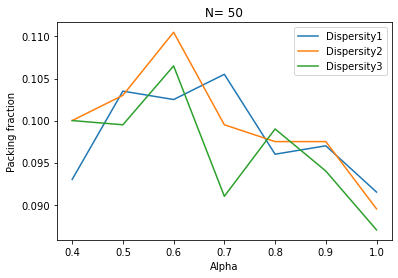

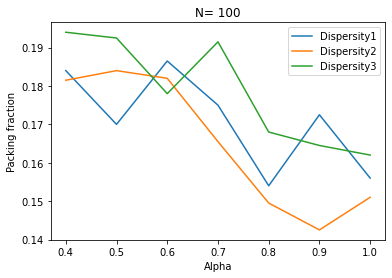

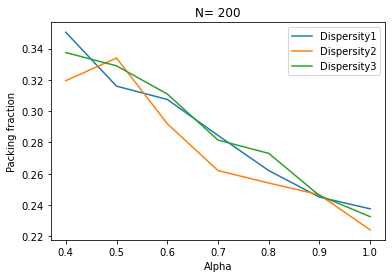

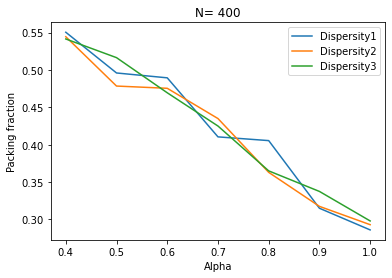

In [100]:
for i in [50,100, 200, 400]:
    createPlot(i)

## Table of statistical accuracy

In [101]:
def accuracy(dispersity, overlapConstant, NParticles, NSample, NRep):
    fractions = np.array([])
    for i in range(NRep):
        discArray = addDiscs(NParticles, dispersity, overlapConstant)
        fractions = np.append(fractions, (packingFraction(discArray, NSample)))

    sum = 0
    for x in range(NRep):
        sum += (np.mean(fractions) - fractions[x])**2

    acc = np.sqrt(sum/NRep)

    return acc

print('Dispersity NSample NRep Accuracy')

for i in range(1,4):
    for x in [100,200,400]:
        for c in [10,20,40,80]:
            print('{0} {1} {2} {3}'.format(i,x,c,accuracy(i,1,1000,x,c)))

Dispersity NSample NRep Accuracy
1 100 10 0.04943682837723311
1 100 20 0.0460733111464761
1 100 40 0.053145437245355316
1 100 80 0.055778440055275824
1 200 10 0.02739069184960467
1 200 20 0.04456105362309109
1 200 40 0.032517062828613545
1 200 80 0.039448542431882075
1 400 10 0.02968690788883207
1 400 20 0.022051077071199954
1 400 40 0.029186295478357643
1 400 80 0.02652232255572653
2 100 10 0.060835844697020525
2 100 20 0.059632206063502294
2 100 40 0.055632162460217204
2 100 80 0.04793159187842608
2 200 10 0.029000000000000015
2 200 20 0.024762623043611518
2 200 40 0.04000605422932885
2 200 80 0.02809797312529856
2 400 10 0.02378155798092294
2 400 20 0.024550967394381847
2 400 40 0.024757495708370825
2 400 80 0.03048371427397752
3 100 10 0.039102429592034305
3 100 20 0.057225431409470395
3 100 40 0.04089544595673216
3 100 80 0.055800985654377105
3 200 10 0.033124764150103764
3 200 20 0.04026785318340177
3 200 40 0.031078278185896986
3 200 80 0.03676992444580216
3 400 10 0.04225591674